In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import requests

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the data folder as the working directory
data_folder = r"D:\Benson\aUpWork\Ben Ruff\Implementation\Data"
os.chdir(data_folder)

# Print the current working directory to verify it
print("Current working directory:", os.getcwd())

Current working directory: D:\Benson\aUpWork\Ben Ruff\Implementation\Data


In [4]:
# Import the the CSV files with the historical data
spy_df = pd.read_csv("SPY.csv")
spy_dividends_df = pd.read_csv("SPY Dividends.csv")
vti_df = pd.read_csv("VTI.csv")
vti_dividends_df = pd.read_csv("VTI Dividends.csv")

In [5]:
# Convert 'Date' columns to datetime and set as index
for df in [spy_df, spy_dividends_df, vti_df, vti_dividends_df]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

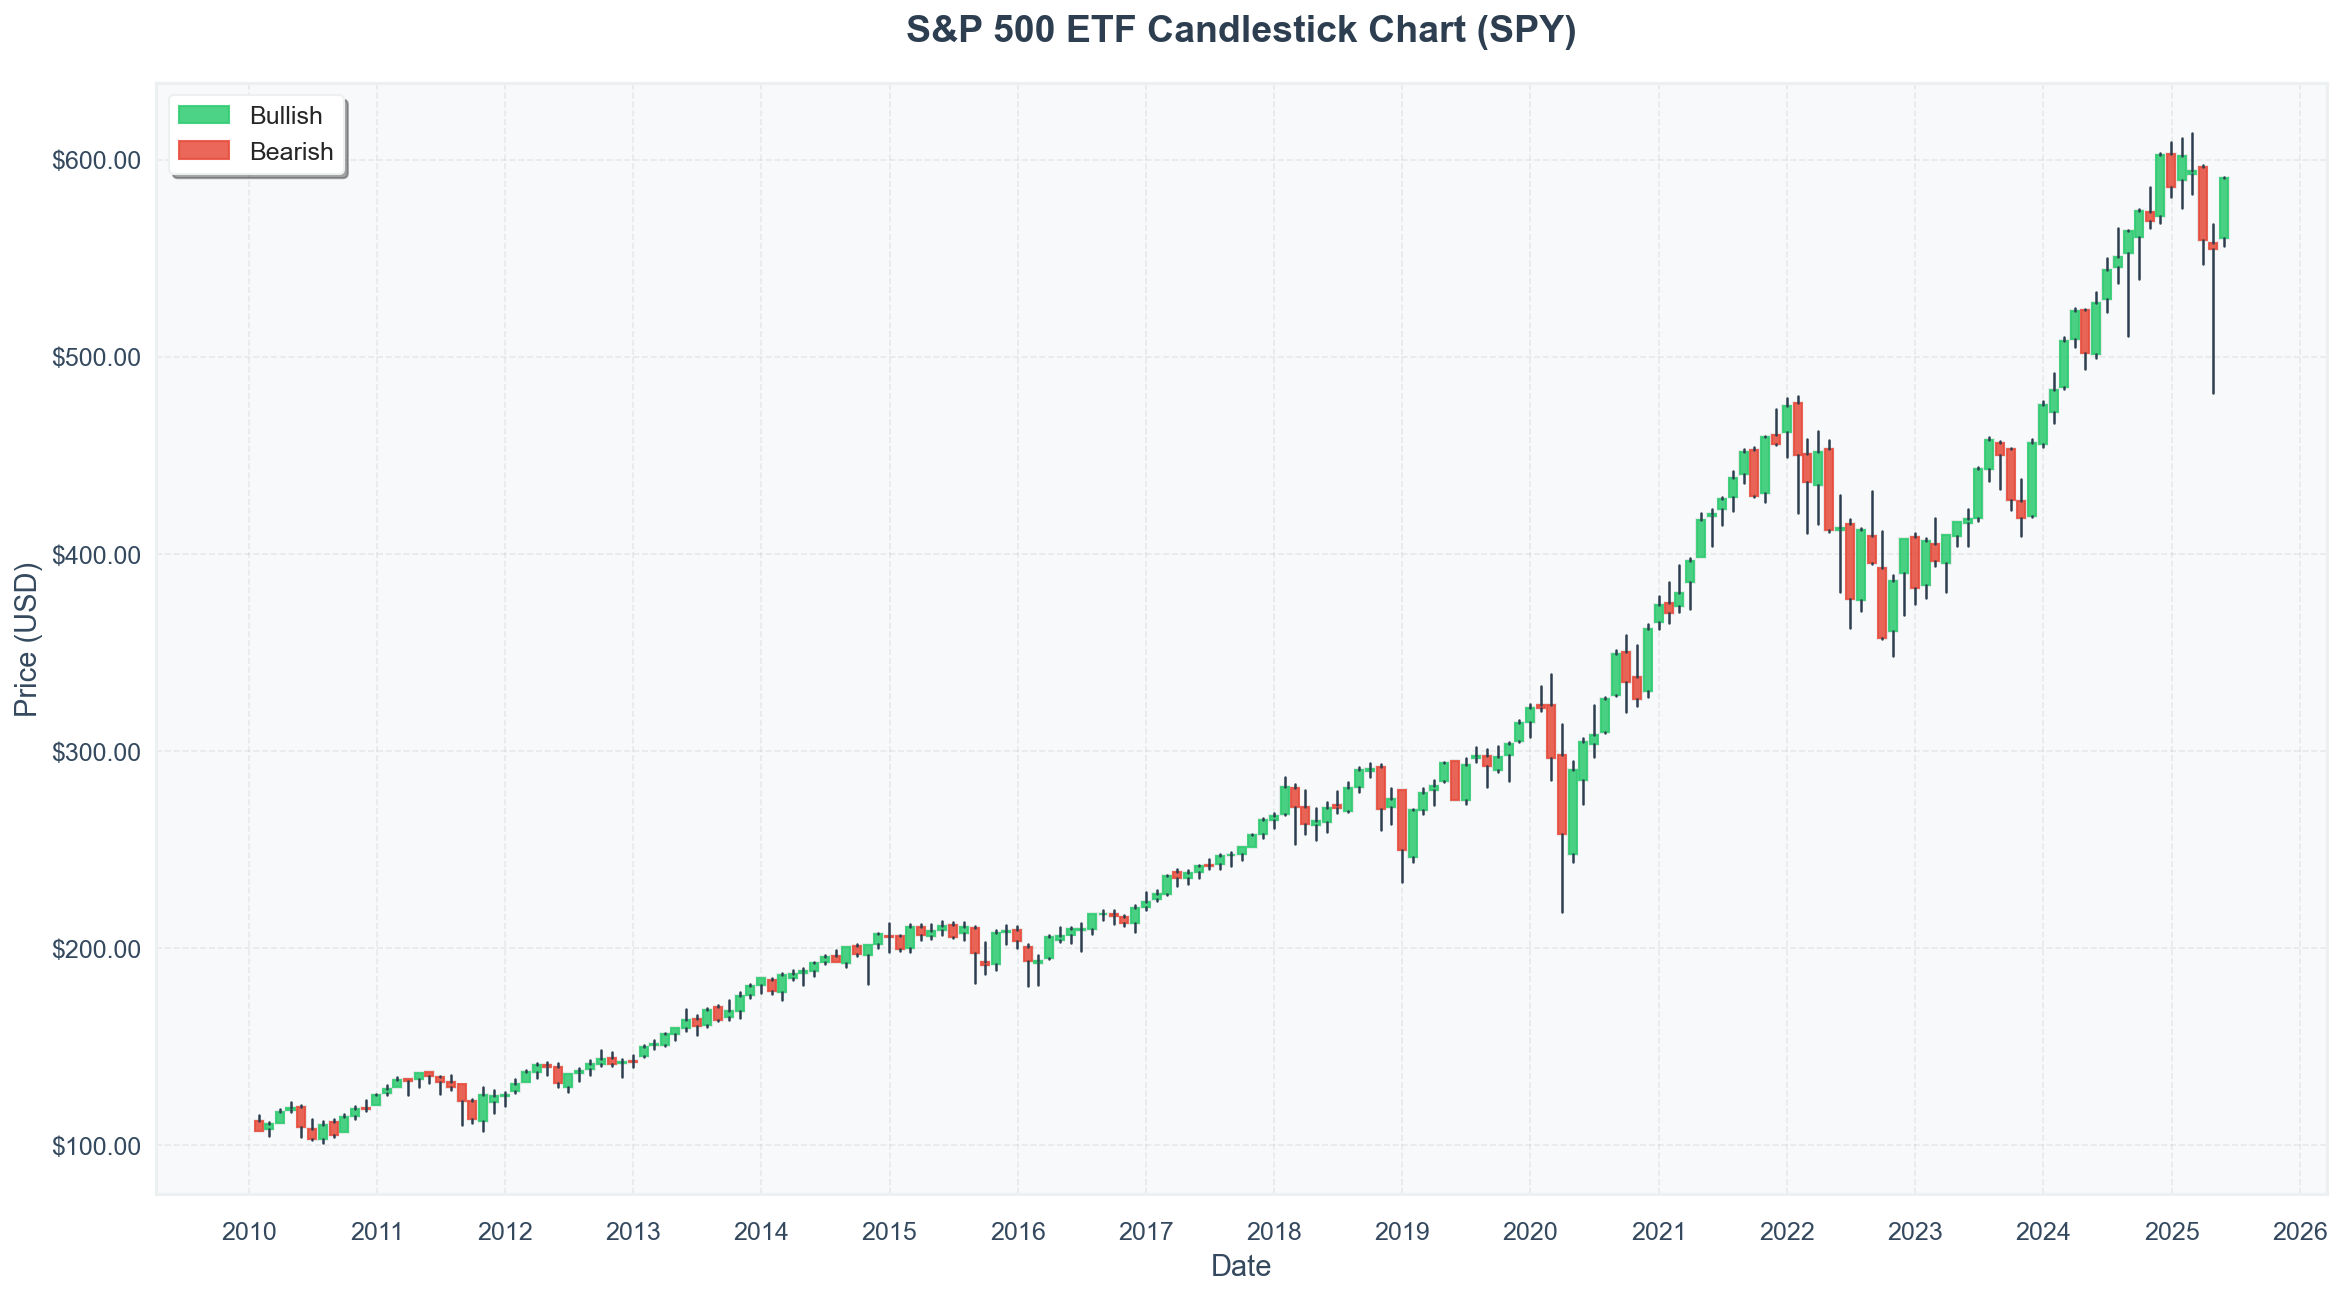

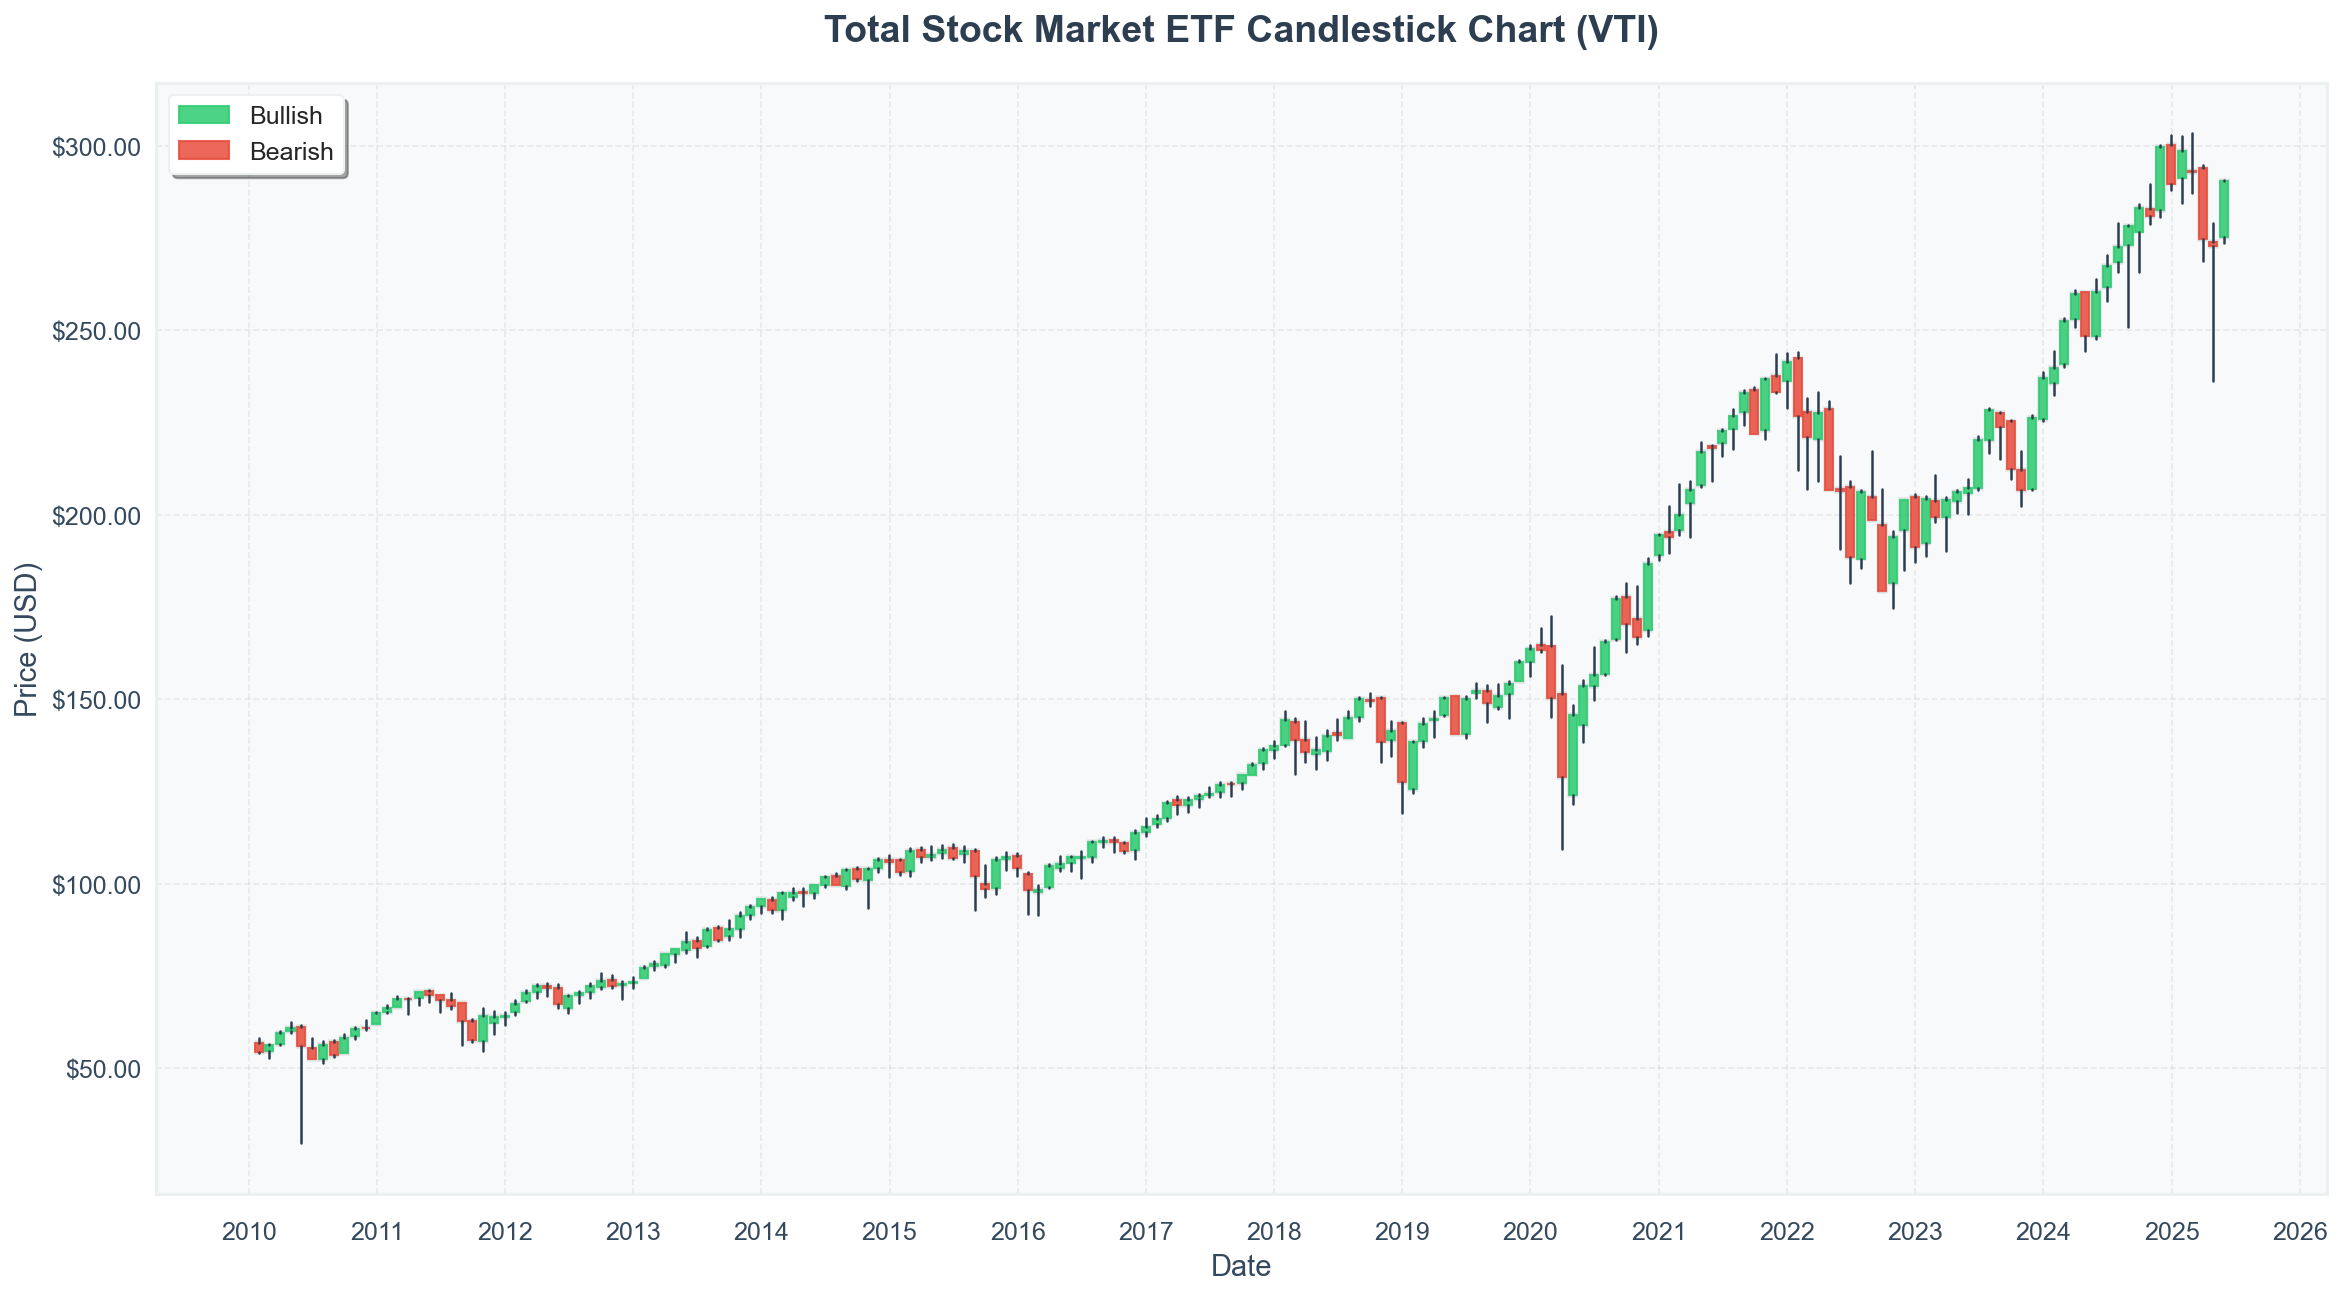

In [6]:
# Set seaborn style with custom parameters for a modern look
sns.set_style("whitegrid", {
    'grid.linestyle': '--',
    'grid.alpha': 0.2,
    'axes.facecolor': '#f8f9fa',
    'figure.facecolor': '#ffffff',
})

# Function to create enhanced candlestick plot
def plot_candlestick(df, title, symbol='Stock'):
    # Resample data to monthly for better visualization
    df_resampled = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    })
    
    # Create figure with high resolution
    fig, ax = plt.subplots(figsize=(16, 9), dpi=150)
    
    # Calculate dates and candlestick width
    dates = mdates.date2num(df_resampled.index.to_pydatetime())
    avg_dist = np.mean(np.diff(dates)) if len(dates) > 1 else 1
    width = avg_dist * 0.75
    shadow_width = width * 0.05
    
    # Define colors for a premium look
    up_color = '#2ecc71'  # Vibrant green
    down_color = '#e74c3c'  # Rich red
    wick_color = '#2c3e50'  # Dark slate
    shadow_color = '#95a5a6'  # Subtle gray for shadows
    
    # Separate up and down days
    up = df_resampled[df_resampled.Close >= df_resampled.Open]
    down = df_resampled[df_resampled.Close < df_resampled.Open]
    
    # Plot candlesticks with shadows and gradient effect
    for i, (idx, row) in enumerate(df_resampled.iterrows()):
        date_val = dates[df_resampled.index.get_indexer([idx])[0]]
        is_up = row.Close >= row.Open
        
        # Add subtle shadow for depth
        shadow = Rectangle(
            (date_val - width/2 - shadow_width, min(row.Open, row.Close) - 0.5),
            width + 2*shadow_width,
            abs(row.Close - row.Open) + 1,
            color=shadow_color,
            alpha=0.15,
            zorder=1
        )
        ax.add_patch(shadow)
        
        # Main candlestick body
        rect = Rectangle(
            (date_val - width/2, row.Open),
            width,
            row.Close - row.Open,
            fill=True,
            color=up_color if is_up else down_color,
            alpha=0.85,
            zorder=3
        )
        ax.add_patch(rect)
        
        # Wicks with slight gradient
        ax.plot([date_val, date_val], 
                [row.Low, min(row.Open, row.Close)], 
                color=wick_color, 
                linewidth=1.2, 
                zorder=4)
        ax.plot([date_val, date_val], 
                [max(row.Open, row.Close), row.High], 
                color=wick_color, 
                linewidth=1.2, 
                zorder=4)
    
    # Customize axes
    ax.set_title(f'{title} ({symbol})', fontsize=18, fontweight='bold', pad=20,
                 color='#2c3e50', fontfamily='Arial')
    ax.set_xlabel('Date', fontsize=14, fontweight='medium', color='#34495e')
    ax.set_ylabel('Price (USD)', fontsize=14, fontweight='medium', color='#34495e')
    
    # Enhanced date formatting
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=12, colors='#34495e')
    ax.tick_params(axis='x', which='major', pad=10)
    
    # Format y-axis with dollar signs
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.2f}'))
    
    # Add subtle grid
    ax.grid(True, which='major', linestyle='--', alpha=0.3, color='#bdc3c7')
    
    # Add legend with modern styling
    green_patch = Rectangle((0, 0), 1, 1, color=up_color, alpha=0.85)
    red_patch = Rectangle((0, 0), 1, 1, color=down_color, alpha=0.85)
    ax.legend([green_patch, red_patch], ['Bullish', 'Bearish'],
              loc='upper left',
              fontsize=12,
              frameon=True,
              facecolor='#ffffff',
              edgecolor='#ecf0f1',
              shadow=True,
              fancybox=True)
    
    # Add subtle border around plot
    for spine in ax.spines.values():
        spine.set_edgecolor('#ecf0f1')
        spine.set_linewidth(1.5)
    
    # Optimize layout
    plt.tight_layout(pad=2)

    return fig, ax

# Example usage:
# Filter data from 2010 to present
start_date = '2010-01-01'
end_date = spy_df.index[-1].strftime('%Y-%m-%d')

# Assuming spy_df and vti_df are available
# Plot SPY data
spy_filtered = spy_df.loc[start_date:end_date]
fig, ax = plot_candlestick(spy_filtered, 'S&P 500 ETF Candlestick Chart', 'SPY')

# Plot VTI data
vti_filtered = vti_df.loc[start_date:end_date]
fig, ax = plot_candlestick(vti_filtered, 'Total Stock Market ETF Candlestick Chart', 'VTI')

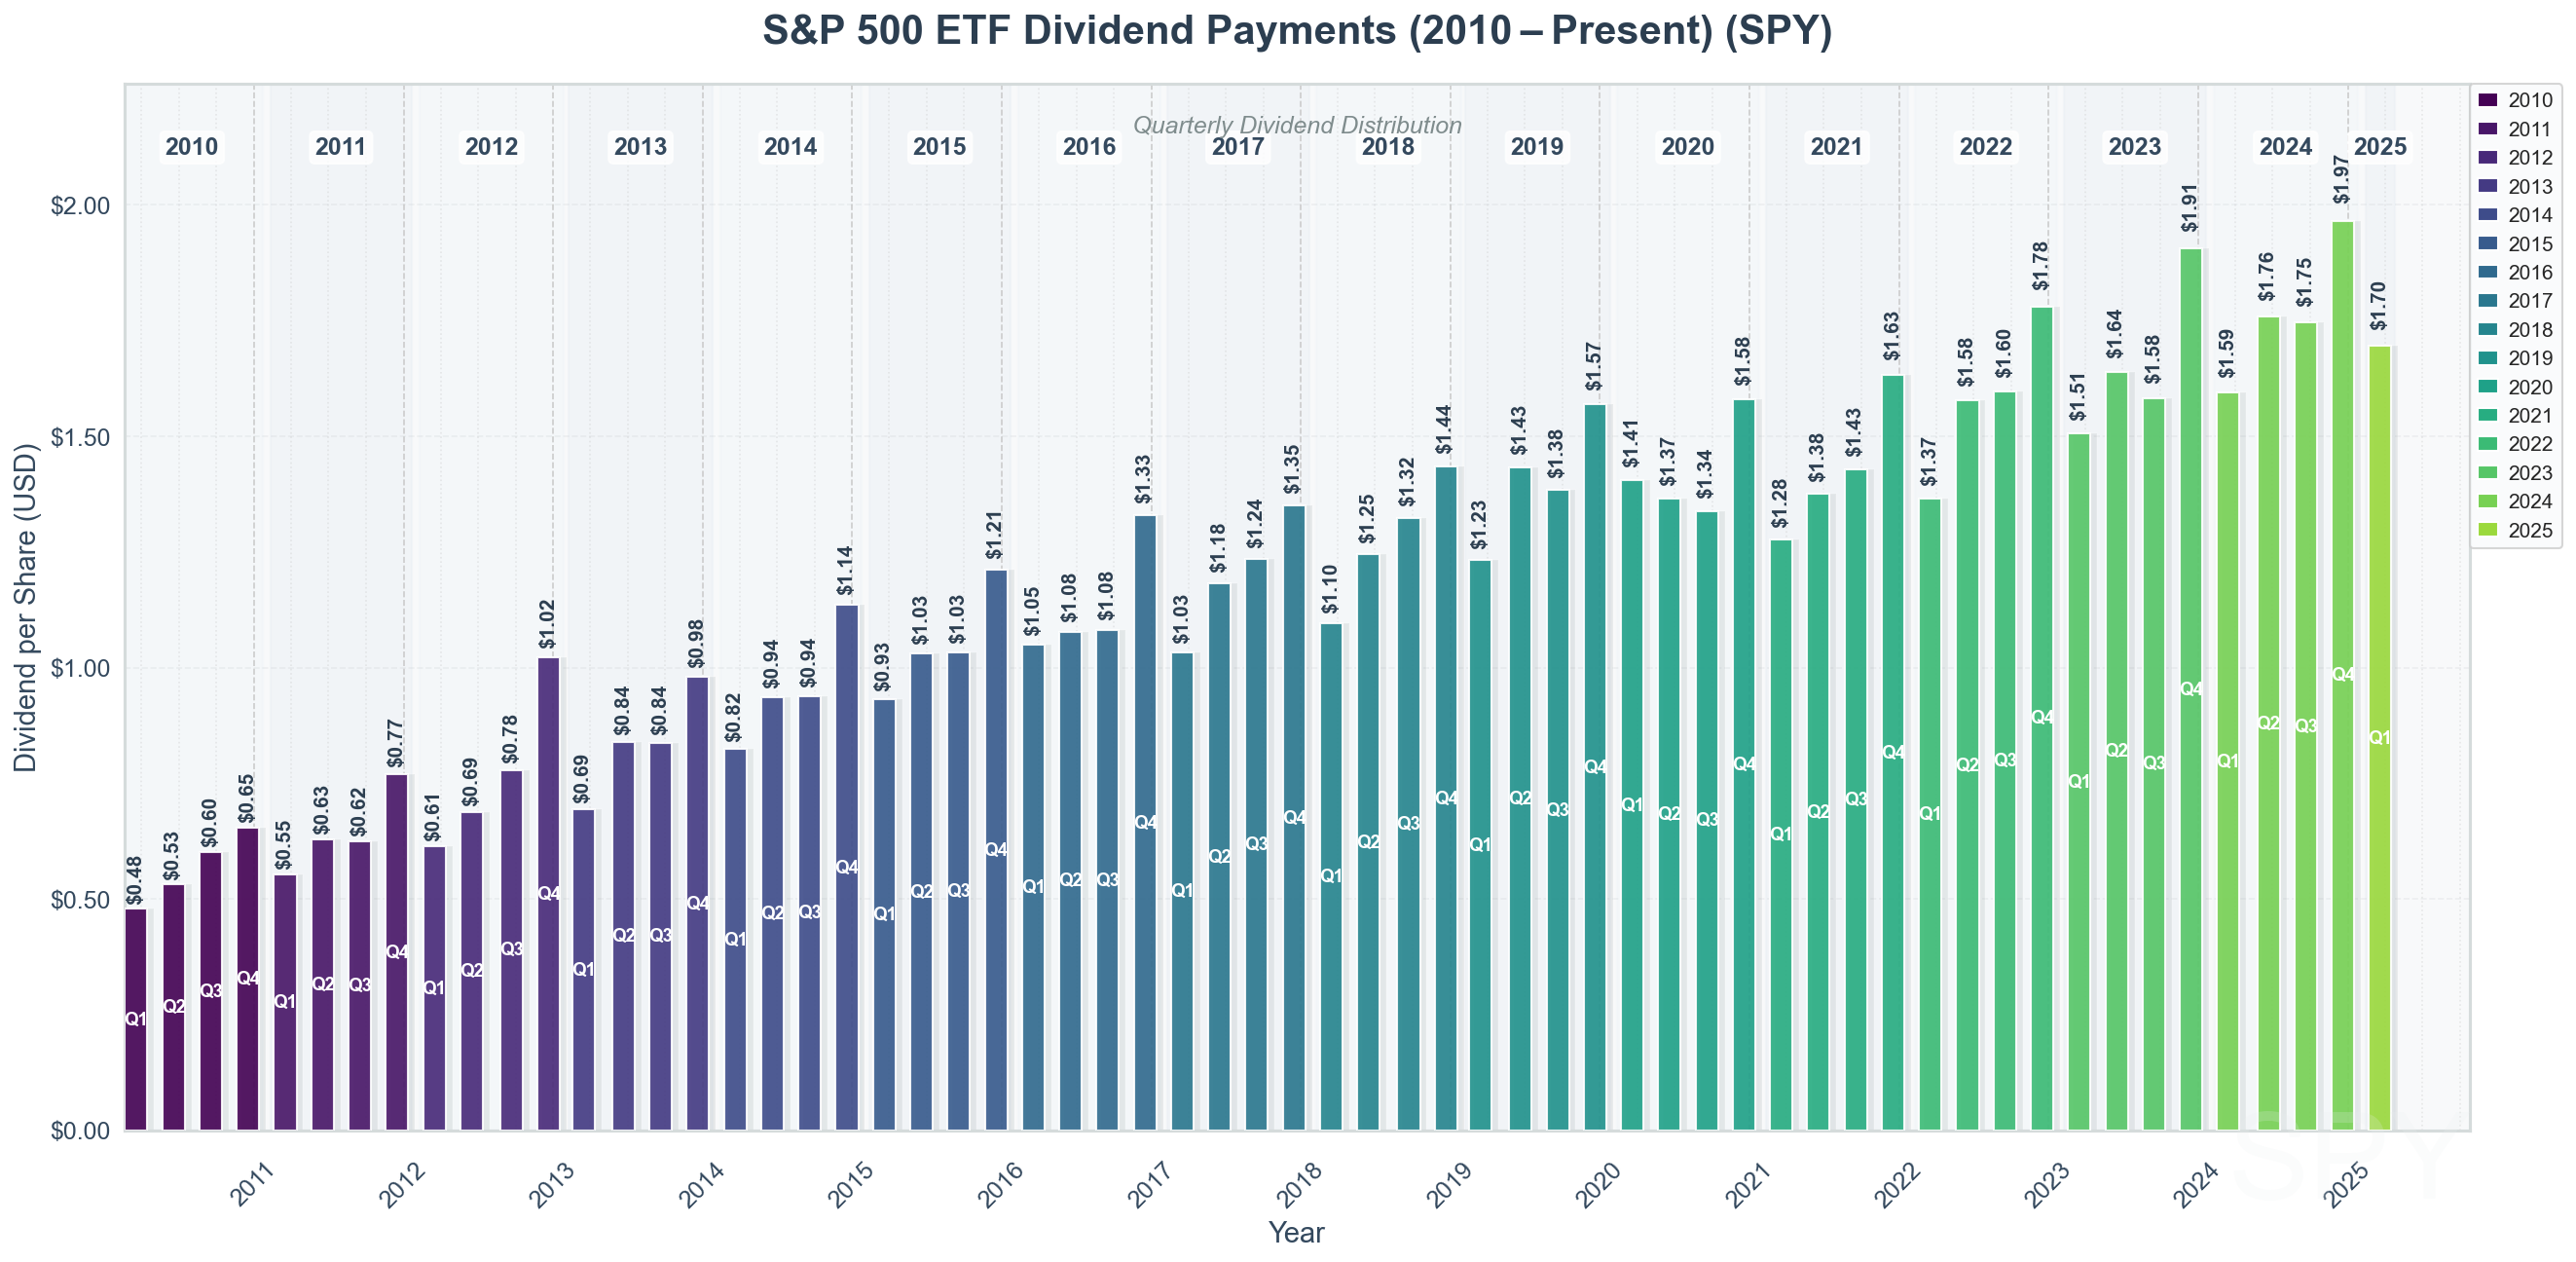

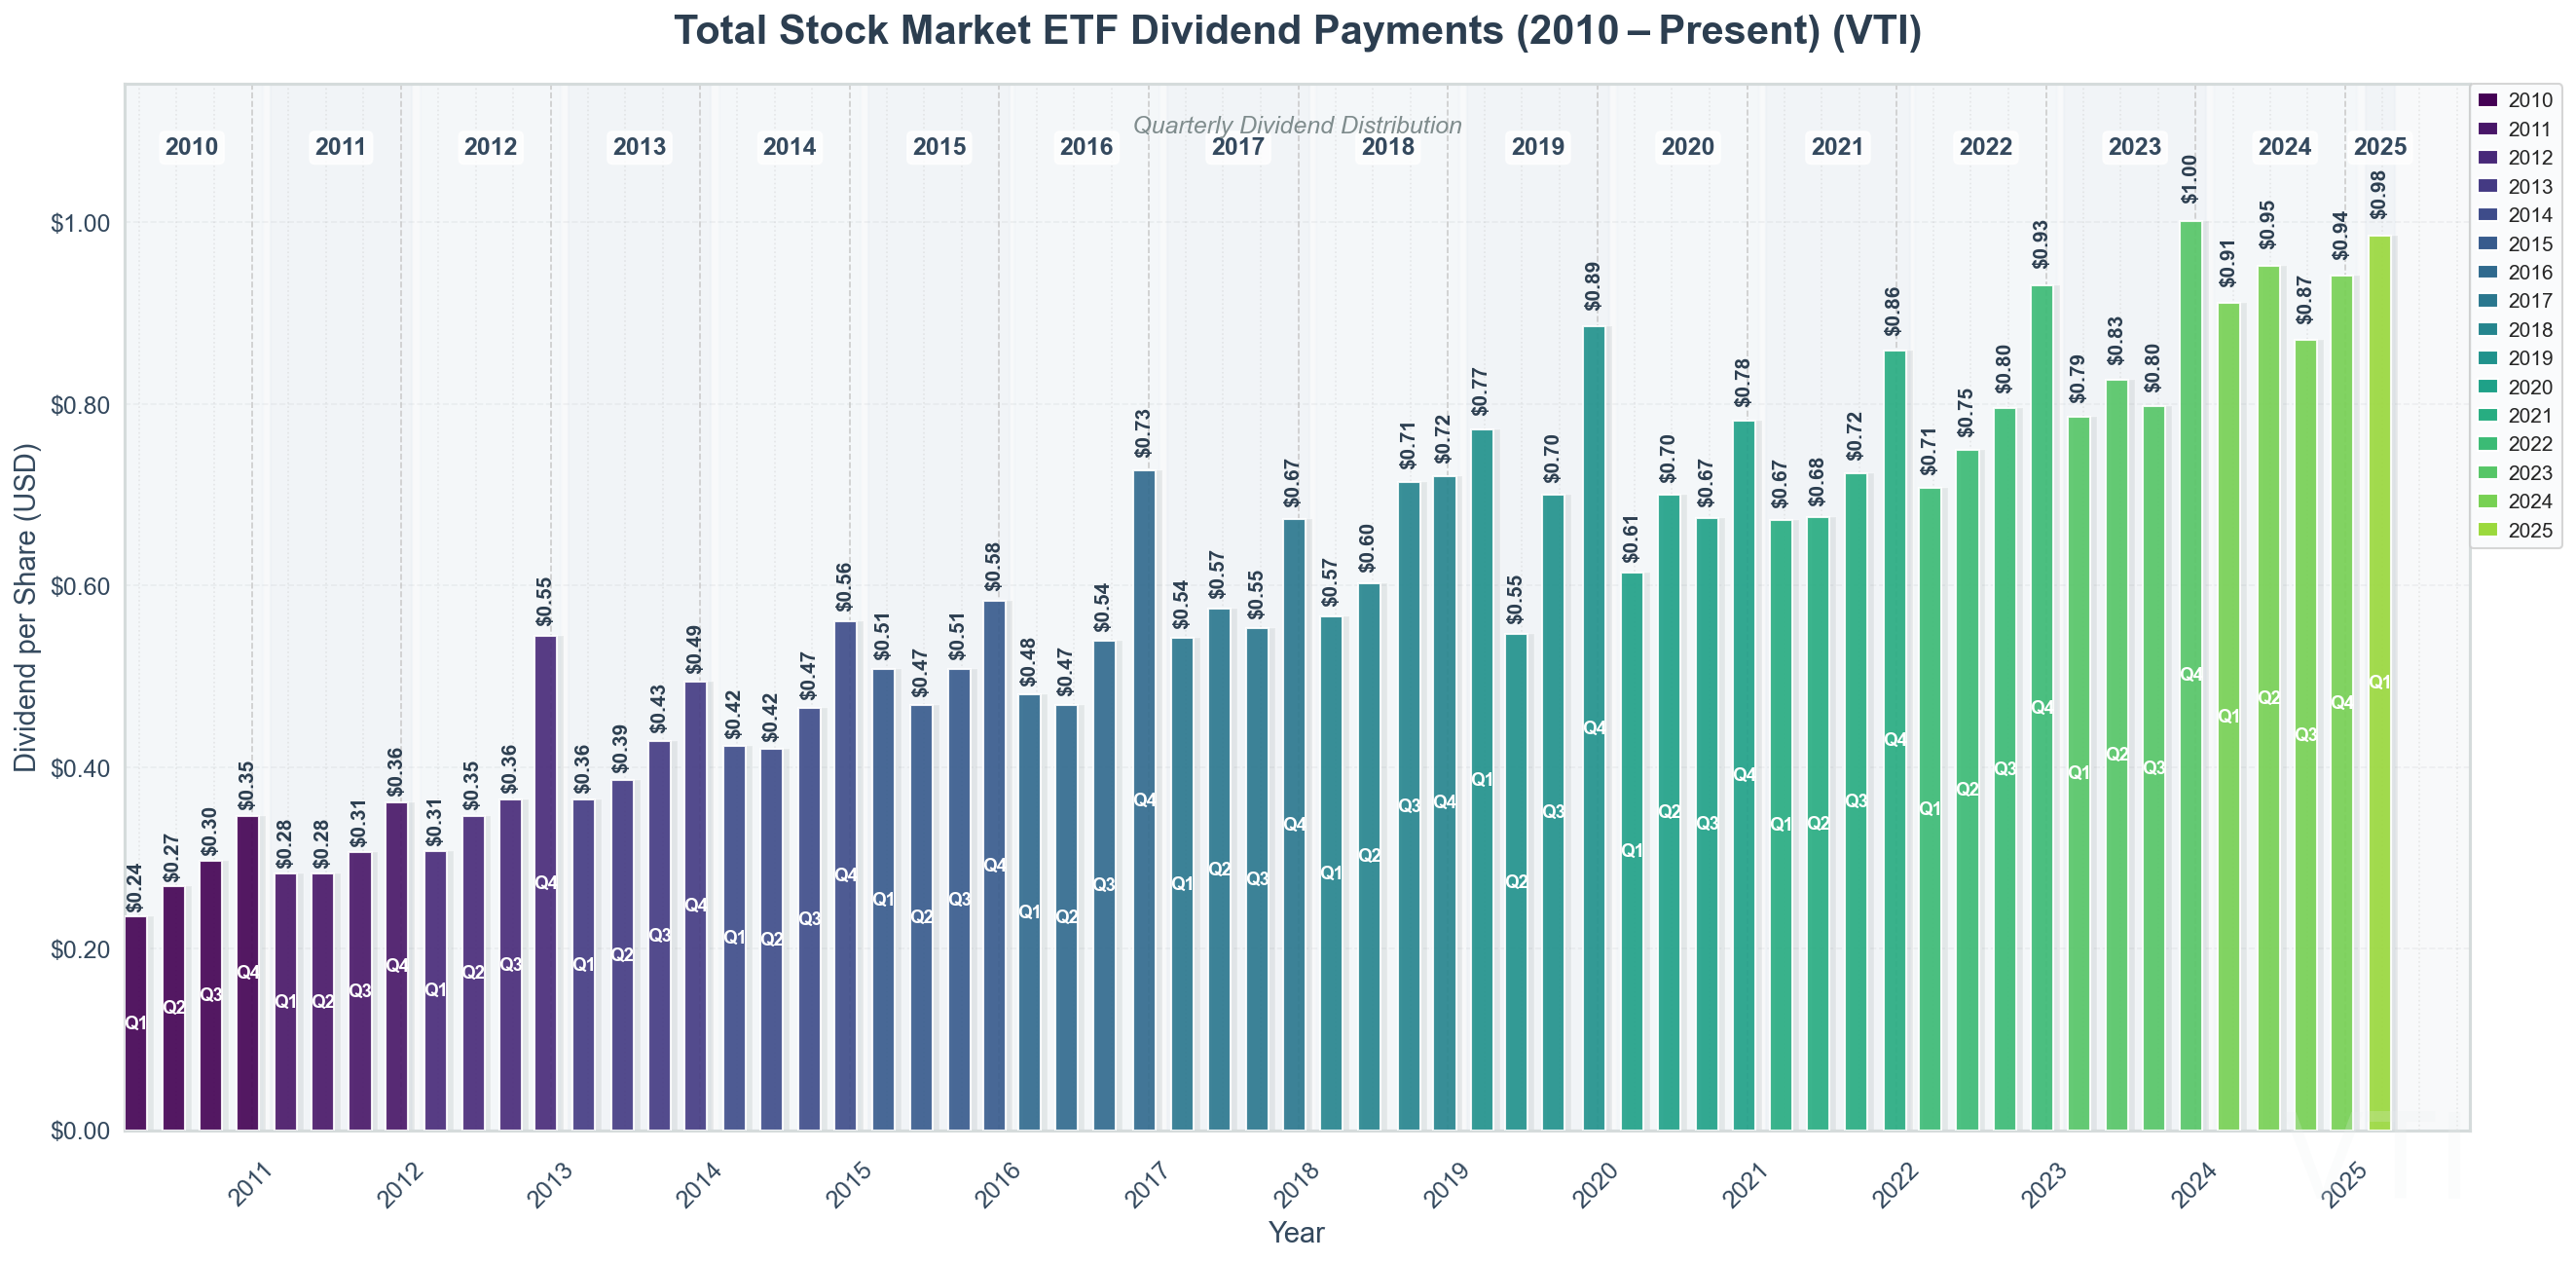

In [7]:
# Function to plot dividend bars
def plot_dividend_bars(df, title, symbol='Stock', width_factor=0.6):
    if 'Dividends' not in df.columns:
        raise ValueError("DataFrame must contain a 'Dividends' column")
    
    #— figure & style
    fig, ax = plt.subplots(figsize=(18, 9), dpi=150)
    sns.set_style("whitegrid", {
        'grid.linestyle': '--', 'grid.alpha': 0.2,
        'axes.facecolor': '#f9fbfc', 'figure.facecolor': '#ffffff',
    })
    ax.set_facecolor('#f8f9fa')
    
    #— compute bar positions & widths
    dates = mdates.date2num(df.index.to_pydatetime())
    avg_dist = np.mean(np.diff(dates)) if len(dates) > 1 else 1
    bar_width = avg_dist * width_factor
    
    #— year bands & labels (works for both SPY & VTI)
    years = df.index.year.unique()
    colors = plt.cm.viridis(np.linspace(0, 0.85, len(years)))
    year_to_color = dict(zip(sorted(years), colors))
    prev, start = None, None
    bands = []
    for i, dt in enumerate(df.index):
        y = dt.year
        if y != prev:
            if prev is not None:
                bands.append((start, i-1, prev))
            start = i
            prev = y
    bands.append((start, len(df)-1, prev))
    
    # Use different y position for year labels depending on symbol
    for idx, (s, e, y) in enumerate(bands):
        left = dates[s] - bar_width/1.5
        right = dates[e] + bar_width/1.5
        color = '#f0f4f8' if idx % 2 == 0 else '#e8eef3'
        ax.axvspan(left, right, color=color, alpha=0.4, zorder=0)
        mid = (left + right)/2
        if symbol == 'SPY':
            year_y = ax.get_ylim()[1]*2.1
        elif symbol == 'VTI':
            year_y = ax.get_ylim()[1]*1.07
        else:
            year_y = ax.get_ylim()[1]*1.01
        ax.text(mid, year_y, str(y),
                ha='center', va='bottom', fontsize=12,
                fontweight='bold', color='#34495e',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
    
    #— bars & annotations
    for i, (dt, row) in enumerate(df.iterrows()):
        x = dates[i]
        div = row['Dividends']
        ycol = year_to_color[dt.year]
        # shadow
        ax.bar(x+bar_width/4, div, width=bar_width*1.1,
               color='#7f8c8d', alpha=0.15, zorder=1)
        # main
        ax.bar(x, div, width=bar_width, color=ycol, alpha=0.9, zorder=3)
        # quarter label
        q = (dt.month-1)//3 + 1
        ax.text(x, div/2, f'Q{q}',
                ha='center', va='center', fontsize=9,
                fontweight='bold', color='white', zorder=5)
        # dividend value
        ax.text(x, div + div*0.02, f'${div:.2f}',
                ha='center', va='bottom', fontsize=10,
                fontweight='bold', color='#2c3e50',
                rotation=90, zorder=4)
    
    #— axis titles & formatting
    ax.set_title(f'{title} ({symbol})', fontsize=20,
                 fontweight='bold', pad=20, color='#2c3e50')
    ax.text(0.5, 0.97, 'Quarterly Dividend Distribution',
            ha='center', va='top', transform=ax.transAxes,
            fontsize=12, fontstyle='italic', color='#7f8c8d')
    ax.set_xlabel('Year', fontsize=14, fontweight='medium', color='#34495e')
    ax.set_ylabel('Dividend per Share (USD)', fontsize=14,
                  fontweight='medium', color='#34495e')
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator([1,4,7,10]))
    ax.grid(which='minor', axis='x', linestyle=':', alpha=0.4, zorder=0)
    ax.grid(which='major', axis='y', linestyle='--', alpha=0.2, color='#bdc3c7')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.2f}'))
    ax.tick_params(axis='both', which='major', labelsize=12, colors='#34495e')
    ax.tick_params(axis='x', which='major', width=6, direction='out', pad=10, rotation=45)
    
    #— clip top margins so annotations fit
    top = df['Dividends'].max() * 1.15
    ax.set_ylim(0, top)
    
    #— remove space before 2010 & add room after last bar
    first, last = dates[0], dates[-1]
    ax.set_xlim(first - bar_width/2, last + bar_width*4)
    
    #— hide that “2026” tick label and build legend there
    for lbl in ax.get_xticklabels():
        if lbl.get_text() == '2026':
            lbl.set_visible(False)
    
    legend_years = [y for y in sorted(years) if y != 2026]
    legend_elements = [
        Patch(facecolor=year_to_color[y], label=str(y))
        for y in legend_years
    ]
    ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1, 1),
        loc='upper left',
        borderaxespad=0,
        handlelength=1,
        handletextpad=0.5,
        fontsize=10,
        frameon=True
    )
    
    #— polished spines & watermark
    for spine in ax.spines.values():
        spine.set_edgecolor('#d5dbdb')
        spine.set_linewidth(1.5)
    fig.text(0.95, 0.05, symbol, fontsize=60,
             color='#ecf0f1', ha='right', va='bottom', alpha=0.2)
    
    plt.tight_layout(pad=2)
    # Removed plt.savefig to prevent exporting the plot
    return fig, ax

# Then call exactly as before:
spy_df_filtered = spy_dividends_df.loc['2010-01-01':]
vti_df_filtered = vti_dividends_df.loc['2010-01-01':]
fig1, ax1 = plot_dividend_bars(spy_df_filtered,
    'S&P 500 ETF Dividend Payments (2010 – Present)', 'SPY')
fig2, ax2 = plot_dividend_bars(vti_df_filtered,
    'Total Stock Market ETF Dividend Payments (2010 – Present)', 'VTI')


In [8]:
# Merge SPY price data with its dividends as a new column, filling missing dividends with 0
spy_merged = spy_df[['Close']].copy()
spy_merged['Dividend'] = spy_dividends_df['Dividends'].reindex(spy_merged.index).fillna(0)
spy_merged.rename(columns={'Close': 'SPY', 'Dividend': 'SPY_Dividends'}, inplace=True)

# Merge VTI price data with its dividends as a new column, filling missing dividends with 0
vti_merged = vti_df[['Close']].copy()
vti_merged['Dividend'] = vti_dividends_df['Dividends'].reindex(vti_merged.index).fillna(0)
vti_merged.rename(columns={'Close': 'VTI', 'Dividend': 'VTI_Dividends'}, inplace=True)    

# preview the head of the two merged dataframes by printing the first 5 rows
print(spy_merged.head())
print(vti_merged.head())


                 SPY  SPY_Dividends
Date                               
1993-01-29  43.93750            0.0
1993-02-01  44.25000            0.0
1993-02-02  44.34375            0.0
1993-02-03  44.81250            0.0
1993-02-04  45.00000            0.0
                  VTI  VTI_Dividends
Date                                
2001-06-15  55.665001            0.0
2001-06-18  55.310001            0.0
2001-06-19  55.465000            0.0
2001-06-20  56.049999            0.0
2001-06-21  56.500000            0.0


In [9]:
# descriptive statistics of the ETFs
merged_df = spy_merged.join(vti_merged, how='outer')
merged_df.describe()

,SPY,SPY_Dividends,VTI,VTI_Dividends
count,8130.000000,8130.000000,6015.000000,6015.000000
mean,186.521469,0.012571,111.467947,0.007513
std,129.600174,0.115138,67.004605,0.066396
min,43.406250,0.000000,33.700001,0.000000
25%,107.174999,0.000000,59.157499,0.000000
50%,134.320312,0.000000,84.209999,0.000000
75%,237.022499,0.000000,147.020004,0.000000
max,612.929993,1.966000,303.119995,1.002000


In [10]:
# info checks the data types and the number of non-null values
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8130 entries, 1993-01-29 to 2025-05-15
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SPY            8130 non-null   float64
 1   SPY_Dividends  8130 non-null   float64
 2   VTI            6015 non-null   float64
 3   VTI_Dividends  6015 non-null   float64
dtypes: float64(4)
memory usage: 317.6 KB


Final portfolio value (with dividend reinvestment): $68,899.70
Total return: 589.00%


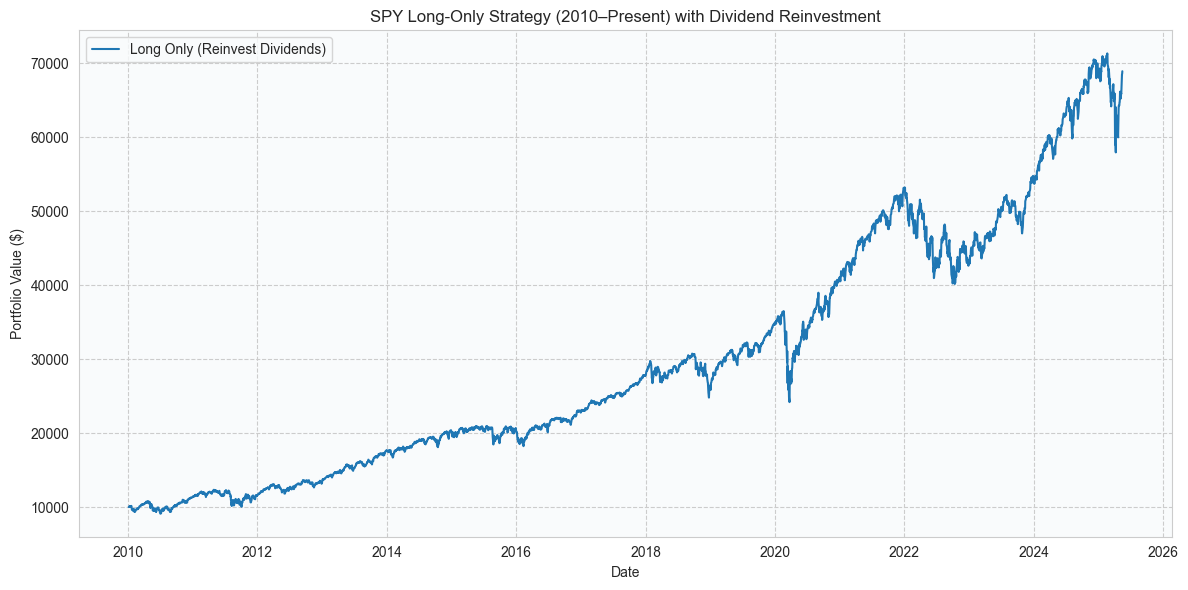

In [11]:
# Implement a long-only strategy on SPY from Jan 2010 to present, reinvesting dividends
# Show step-by-step building of all variables as columns, as if in Excel

# Use the already prepared spy_merged DataFrame (with 'SPY' and 'SPY_Dividends' columns)
# Filter for the period from 2010-01-01 onwards
spy_long = spy_merged.loc['2010-01-01':].copy()

# Assume we start with $1,000 initial capital
initial_capital = 10_000.0

# Initialize columns for step-by-step calculation
spy_long['Start_Capital'] = 0.0
spy_long['Shares_Begin'] = 0.0
spy_long['Dividend_per_Share'] = spy_long['SPY_Dividends']
spy_long['Dividends_Received'] = 0.0
spy_long['Shares_Added'] = 0.0
spy_long['Shares_End'] = 0.0
spy_long['Portfolio_Value'] = 0.0

# Set initial values for the first row
spy_long.iloc[0, spy_long.columns.get_loc('Start_Capital')] = initial_capital
spy_long.iloc[0, spy_long.columns.get_loc('Shares_Begin')] = initial_capital / spy_long['SPY'].iloc[0]
spy_long.iloc[0, spy_long.columns.get_loc('Dividends_Received')] = 0.0
spy_long.iloc[0, spy_long.columns.get_loc('Shares_Added')] = 0.0
spy_long.iloc[0, spy_long.columns.get_loc('Shares_End')] = spy_long.iloc[0, spy_long.columns.get_loc('Shares_Begin')]
spy_long.iloc[0, spy_long.columns.get_loc('Portfolio_Value')] = spy_long.iloc[0, spy_long.columns.get_loc('Shares_End')] * spy_long['SPY'].iloc[0]

# Step through each day, updating all columns
for i in range(1, len(spy_long)):
    prev_idx = i - 1
    # Start capital is always 0 after the first day (for clarity)
    spy_long.iloc[i, spy_long.columns.get_loc('Start_Capital')] = 0.0
    # Shares at the beginning of the day is shares at end of previous day
    spy_long.iloc[i, spy_long.columns.get_loc('Shares_Begin')] = spy_long.iloc[prev_idx, spy_long.columns.get_loc('Shares_End')]
    # Dividend per share for the day (already set)
    dividend_per_share = spy_long.iloc[i, spy_long.columns.get_loc('Dividend_per_Share')]
    # Dividends received = shares held at start of day * today's dividend per share
    dividends_received = spy_long.iloc[i, spy_long.columns.get_loc('Shares_Begin')] * dividend_per_share
    spy_long.iloc[i, spy_long.columns.get_loc('Dividends_Received')] = dividends_received
    # Shares added = dividends received / today's closing price
    shares_added = dividends_received / spy_long['SPY'].iloc[i] if spy_long['SPY'].iloc[i] != 0 else 0.0
    spy_long.iloc[i, spy_long.columns.get_loc('Shares_Added')] = shares_added
    # Shares at end of day = shares at start + shares added
    shares_end = spy_long.iloc[i, spy_long.columns.get_loc('Shares_Begin')] + shares_added
    spy_long.iloc[i, spy_long.columns.get_loc('Shares_End')] = shares_end
    # Portfolio value = shares at end of day * today's closing price
    spy_long.iloc[i, spy_long.columns.get_loc('Portfolio_Value')] = shares_end * spy_long['SPY'].iloc[i]

# For convenience, also add a 'Shares' column (same as Shares_End)
spy_long['Shares'] = spy_long['Shares_End']

# Print the final portfolio value and total return
final_value = spy_long['Portfolio_Value'].iloc[-1]
total_return = (final_value / initial_capital - 1) * 100
print(f"Final portfolio value (with dividend reinvestment): ${final_value:,.2f}")
print(f"Total return: {total_return:.2f}%")

# Optionally, plot the portfolio value over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(spy_long.index, spy_long['Portfolio_Value'], label='Long Only (Reinvest Dividends)')
plt.title('SPY Long-Only Strategy (2010–Present) with Dividend Reinvestment')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# export spy_long to excel
spy_long.to_excel("spy_long.xlsx")
spy_long

,SPY,SPY_Dividends,Start_Capital,Shares_Begin,Dividend_per_Share,Dividends_Received,Shares_Added,Shares_End,Portfolio_Value,Shares
Date,,,,,,,,,,
2010-01-04,113.330002,0.0,10000.0,88.237888,0.0,0.0,0.0,88.237888,10000.000000,88.237888
2010-01-05,113.629997,0.0,0.0,88.237888,0.0,0.0,0.0,88.237888,10026.470925,88.237888
2010-01-06,113.709999,0.0,0.0,88.237888,0.0,0.0,0.0,88.237888,10033.530133,88.237888
2010-01-07,114.190002,0.0,0.0,88.237888,0.0,0.0,0.0,88.237888,10075.884584,88.237888
2010-01-08,114.570000,0.0,0.0,88.237888,0.0,0.0,0.0,88.237888,10109.414804,88.237888
...,...,...,...,...,...,...,...,...,...,...
2025-05-09,564.340027,0.0,0.0,116.688173,0.0,0.0,0.0,116.688173,65851.806944,116.688173
2025-05-12,582.989990,0.0,0.0,116.688173,0.0,0.0,0.0,116.688173,68028.037061,116.688173
2025-05-13,586.840027,0.0,0.0,116.688173,0.0,0.0,0.0,116.688173,68477.290846,116.688173


In [14]:
API_KEY = 'e6e584079633bf3ed858770f355b8ad1'  # your FRED key
BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'

params = {
    'series_id': 'FEDFUNDS',   # Effective Federal Funds Rate
    'api_key': API_KEY,
    'file_type': 'json',
    'observation_start': '2000-01-01'  # last 12 years
}
# Removed frequency parameter since FEDFUNDS is only available at monthly frequency

# 1) Download the data
resp = requests.get(BASE_URL, params=params)
resp.raise_for_status()
data = resp.json()

# 2) Build DataFrame
ff = (
    pd.DataFrame(data['observations'])
      .assign(
          date=lambda df: pd.to_datetime(df['date']),
          rate=lambda df: pd.to_numeric(df['value'], errors='coerce')
      )
      .set_index('date')
      [['rate']]
      .rename(columns={'rate':'FedFunds (%)'})
)

# 3) Compute FedFunds + 1.5%
ff['FedFunds + 1.5%'] = ff['FedFunds (%)'] + 1.5

# 4) Save to Excel
ff.to_excel("FED_FUNDS.xlsx", index=True)

# 5) Preview
print(ff.head(6))


            FedFunds (%)  FedFunds + 1.5%
date                                     
2000-01-01          5.45             6.95
2000-02-01          5.73             7.23
2000-03-01          5.85             7.35
2000-04-01          6.02             7.52
2000-05-01          6.27             7.77
2000-06-01          6.53             8.03


In [17]:
# Merge the merged dataframe with Fama-French factors
final_df = pd.merge(merged_df, ff, left_index=True, right_index=True, how='outer')

# Drop all data before 2001-06-15
final_df = final_df[final_df.index >= '2001-07-01']

# Forward fill the FedFunds data to fill missing values within each month
final_df['FedFunds (%)'] = final_df['FedFunds (%)'].fillna(method='ffill')

# Calculate FedFunds + 1.5%
final_df['FedFunds + 1.5%'] = final_df['FedFunds (%)'] + 1.5

# drop all NAs
final_df = final_df.dropna()

# Export to Excel
final_df.to_excel('ETFs and Fed Funds Data.xlsx', index=True)

final_df

,SPY,SPY_Dividends,VTI,VTI_Dividends,FedFunds (%),FedFunds + 1.5%
2001-07-02,124.129997,0.0,56.650002,0.0,3.77,5.27
2001-07-03,124.099998,0.0,56.619999,0.0,3.77,5.27
2001-07-05,121.680000,0.0,55.974998,0.0,3.77,5.27
2001-07-06,119.050003,0.0,54.500000,0.0,3.77,5.27
2001-07-09,119.699997,0.0,54.849998,0.0,3.77,5.27
...,...,...,...,...,...,...
2025-05-09,564.340027,0.0,277.970001,0.0,4.33,5.83
2025-05-12,582.989990,0.0,287.269989,0.0,4.33,5.83
2025-05-13,586.840027,0.0,289.220001,0.0,4.33,5.83
2025-05-14,587.590027,0.0,289.410004,0.0,4.33,5.83
